In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
#pd.set_option('display.max_rows', 200)
pd.set_option("display.max_columns", 999)
import uproot
import os
from multiprocessing import Pool
import psutil

import tensorflow as tf
print(tf.__version__)
print(tf.test.is_built_with_cuda())

2023-09-09 11:02:24.418807: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-09 11:02:24.741402: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.10.0
True


In [2]:
def get_min(Ref, Array):
    return np.argmin(np.abs(Ref - Array))

In [3]:
def add_more_cols(DF):
    DF["P1M"] = (DF["Mjj_msortedP1_high"] + DF["Mjj_msortedP1_low"]) / 2
    DF["P2M"] = (DF["Mjj_msortedP2_high"] + DF["Mjj_msortedP2_low"]) / 2
    DF["P3M"] = (DF["Mjj_msortedP3_high"] + DF["Mjj_msortedP3_low"]) / 2
    
    DF["dRi"] = DF.apply(lambda row: get_min(row["Mjj_avg_dRpairing_GeV"], 
                                np.array([row["P1M"], row["P2M"], row["P3M"]])), axis = 1)
    DF["Truth_high"] = DF.apply(lambda row: get_min(row["Mass"], np.array([row["Mjj_msortedP1_high"], 
                                row["Mjj_msortedP2_high"], row["Mjj_msortedP3_high"]])), axis = 1)
    DF["Truth_avg"] = DF.apply(lambda row: get_min(row["Mass"], 
                                np.array([row["P1M"], row["P2M"], row["P3M"]])), axis = 1)
    
    DF["P1QSMD"] = (DF["Mjj_msortedP1_high"] - DF["Mass"])**2 + (DF["Mjj_msortedP1_low"] - DF["Mass"])**2
    DF["P2QSMD"] = (DF["Mjj_msortedP2_high"] - DF["Mass"])**2 + (DF["Mjj_msortedP2_low"] - DF["Mass"])**2
    DF["P3QSMD"] = (DF["Mjj_msortedP3_high"] - DF["Mass"])**2 + (DF["Mjj_msortedP3_low"] - DF["Mass"])**2
    
    DF["Truth_QSMD"] = DF.apply(lambda row: get_min(0, 
                                np.array([row["P1QSMD"], row["P2QSMD"], row["P3QSMD"]])), axis = 1)
    
    DF["y1_sum"] = abs(DF["y12"] + DF["y34"])
    DF["y1_diff"] = abs(DF["y12"] - DF["y34"])
    DF["y2_sum"] = abs(DF["y13"] + DF["y24"])
    DF["y2_diff"] = abs(DF["y13"] - DF["y24"])
    DF["y3_sum"] = abs(DF["y14"] + DF["y23"])
    DF["y3_diff"] = abs(DF["y14"] - DF["y23"])

In [4]:
def normalize_inouts(DF):
    GevCols = ["Mjj_msortedP1_high", "Mjj_msortedP1_low", "Mjj_msortedP2_high", "Mjj_msortedP2_low", 
               "Mjj_msortedP3_high", "Mjj_msortedP3_low", "Mjj_avg_dRpairing_GeV",
               "pt_ordered_jet1_pt", "pt_ordered_jet2_pt", "pt_ordered_jet3_pt", "pt_ordered_jet4_pt"]
    for GevCol in GevCols:
        DF[GevCol] = DF[GevCol] / 1000
        
    return DF

In [5]:
def make_training_and_testing_pd(Mass):
    TrainingRows = 100000
    TestingRows = 50000
    File = "ML_TTree/tree_ML_MCRun2_" + str(Mass) + "GeV.root"
    
    print("Processing file: " + File + "\n")
    Events = uproot.open(File)["tree_ML"]
    DF = Events.arrays(library="pd")
    DF = DF.loc[DF["evt_trig"] == 1].reset_index(drop=True)
    DF["Mass"] = Mass
    add_more_cols(DF)
    normalize_inouts(DF)
    
    TrainingDF = DF.loc[0:TrainingRows-1]
    TestingDF = DF.loc[TrainingRows:TrainingRows+TestingRows-1]
    
    return [TrainingDF, TestingDF]

In [6]:
Masses = [500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000, 2500, 3000]

SanityCheckPlots = False
NotebookName = "quad_sum_mass_diff_CNN_Dropout"
ResultsDir = "results_temp/results_" + NotebookName + "/"
if not os.path.exists(ResultsDir):
    os.makedirs(ResultsDir)

In [7]:
#multithreading and memory monitoring in case large input files in the future
Mem0 = psutil.virtual_memory().available

TrainingDF = None
TestingDF = None
with Pool(processes=6) as pool:
    DFarray = pool.map(make_training_and_testing_pd, Masses)
    TrainingDF =pd.concat([row[0] for row in DFarray], ignore_index=True)
    TestingDF = pd.concat([row[1] for row in DFarray], ignore_index=True)

Mem1 = psutil.virtual_memory().available
print("Memory used: " + str((Mem0 - Mem1)/(1024**3)) + "GB")

Processing file: ML_TTree/tree_ML_MCRun2_800GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_600GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_500GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_1000GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_700GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_900GeV.root




Processing file: ML_TTree/tree_ML_MCRun2_1250GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_1500GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_1750GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_2000GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_2500GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_3000GeV.root

Memory used: 0.9872665405273438GB


In [8]:
#remove a mass point in training and check its performace in testing
#TrainingDF = TrainingDF.loc[TrainingDF["Mass"] != 1000]
TrainingDF

,y12,y34,y13,y24,y14,y23,fourjetmasstev,Mjj_msortedP1_high_div4jm,Mjj_msortedP2_high_div4jm,Mjj_msortedP3_high_div4jm,Mjj_msortedP1_high,Mjj_msortedP1_low,Mjj_msortedP2_high,Mjj_msortedP2_low,Mjj_msortedP3_high,Mjj_msortedP3_low,Mjj_avg_dRpairing_GeV,pt_ordered_jet1_pt,pt_ordered_jet1_eta,pt_ordered_jet1_phi,pt_ordered_jet1_m,pt_ordered_jet2_pt,pt_ordered_jet2_eta,pt_ordered_jet2_phi,pt_ordered_jet2_m,pt_ordered_jet3_pt,pt_ordered_jet3_eta,pt_ordered_jet3_phi,pt_ordered_jet3_m,pt_ordered_jet4_pt,pt_ordered_jet4_eta,pt_ordered_jet4_phi,pt_ordered_jet4_m,evt_trig,Mass,P1M,P2M,P3M,dRi,Truth_high,Truth_avg,P1QSMD,P2QSMD,P3QSMD,Truth_QSMD,y1_sum,y1_diff,y2_sum,y2_diff,y3_sum,y3_diff
0,0.459736,-0.731325,0.492579,-0.572288,-0.136930,0.075227,1.437438,0.589512,0.483189,0.372651,0.847387,0.330702,0.694555,0.515225,0.535663,0.462190,0.498926,0.352612,0.773682,-1.982666,29.824646,0.300181,0.102753,1.098877,57.910728,0.212220,0.038391,-0.279114,12.978419,0.164810,-1.678955,2.421387,19.934750,1,500,589.044722,604.889669,498.926253,2,2,2,1.493393e+05,3.808332e+04,2.701446e+03,2,0.271589,1.191061,0.079709,1.064867,0.061702,0.212157
1,0.177537,-0.046975,0.196526,0.058371,0.045306,0.222323,1.372216,0.731474,0.360959,0.326251,1.003741,0.124972,0.495314,0.481617,0.447687,0.432799,0.564357,0.570987,0.163818,-2.839844,31.241617,0.514659,0.193359,1.086914,30.595160,0.142111,0.331055,-1.069336,22.435198,0.122446,-0.483154,-0.718750,12.957661,1,500,564.356654,488.465821,440.242900,0,1,1,3.944005e+05,3.598749e+02,7.252644e+03,1,0.130562,0.224513,0.254897,0.138155,0.267628,0.177017
2,1.138567,-0.880824,-0.476845,1.483183,0.345174,0.359891,2.415887,0.773636,0.421770,0.326372,1.869017,0.353732,1.018949,0.484321,0.788478,0.574264,0.681371,0.403701,0.345154,-0.989380,39.566208,0.341872,2.052734,1.669922,26.953323,0.181515,-1.941406,-1.693604,23.153996,0.146286,0.351501,-2.593750,15.604961,1,500,1111.374763,751.635244,681.370897,2,2,2,1.895603e+06,2.695539e+05,8.873447e+04,2,0.257743,2.019391,1.006339,1.960028,0.705064,0.014717
3,0.750664,-1.096145,0.298671,-0.234110,0.306175,-0.194680,1.927872,0.589096,0.496342,0.458295,1.135702,0.642779,0.956883,0.457008,0.883534,0.342234,0.706946,0.493272,1.074463,2.465332,29.843073,0.379818,0.339478,-0.009506,37.778255,0.281791,-0.893677,-0.426331,40.116997,0.136930,-1.526611,-2.263184,18.419775,1,500,889.240451,706.945693,612.884215,1,2,2,4.245027e+05,2.105906e+05,1.719886e+05,2,0.345481,1.846808,0.064561,0.532781,0.111494,0.500855
4,-0.508460,-0.847235,-0.673451,-0.477038,-0.610471,-0.564505,1.149871,0.741729,0.417437,0.325977,0.852893,0.145379,0.479999,0.410948,0.374831,0.205845,0.290338,0.467451,-0.590088,-0.751343,52.325665,0.402578,-0.418518,2.844238,32.207481,0.165139,-0.919800,0.644287,13.693277,0.094380,-0.736328,1.830078,17.022684,1,500,499.135929,445.473416,290.337796,2,1,0,2.502898e+05,8.330356e+03,1.021947e+05,1,1.355695,0.338775,1.150489,0.196414,1.174976,0.045966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,-0.123482,-0.125765,0.073410,-0.459019,0.051655,-0.416842,5.470423,0.777138,0.448219,0.424968,4.251276,0.237198,2.451948,0.464031,2.324757,0.526192,1.425474,2.894732,0.096466,0.328125,77.974464,1.444436,-0.555542,3.079102,215.850937,0.523146,-0.053452,-3.068848,41.976273,0.507022,-0.201263,2.809082,44.503277,1,3000,2244.236896,1457.989716,1425.474098,2,1,0,9.198765e+06,6.731498e+06,6.575682e+06,2,0.249246,0.002283,0.385608,0.532429,0.365187,0.468497
1199996,-0.604223,-0.543135,-0.408403,-0.912209,-0.513081,-0.700012,5.158958,0.643059,0.572051,0.216002,3.317512,1.569893,2.951189,1.684289,1.114346,0.661268,0.887807,2.458162,-0.432678,-2.746582,164.295532,1.031057,-1.008545,0.545654,82.479607,0.881092,-0.343689,0.482117,48.013809,0.736507,-0.783691,-2.000000,66.278084,1,3000,2443.702578,2317.739002,887.806600,2,1,0,2.146021e+06,1.733478

In [9]:
TrainingDF.dtypes

y12                          float32
y34                          float32
y13                          float32
y24                          float32
y14                          float32
y23                          float32
fourjetmasstev               float64
Mjj_msortedP1_high_div4jm    float64
Mjj_msortedP2_high_div4jm    float64
Mjj_msortedP3_high_div4jm    float64
Mjj_msortedP1_high           float64
Mjj_msortedP1_low            float64
Mjj_msortedP2_high           float64
Mjj_msortedP2_low            float64
Mjj_msortedP3_high           float64
Mjj_msortedP3_low            float64
Mjj_avg_dRpairing_GeV        float32
pt_ordered_jet1_pt           float32
pt_ordered_jet1_eta          float32
pt_ordered_jet1_phi          float32
pt_ordered_jet1_m            float32
pt_ordered_jet2_pt           float32
pt_ordered_jet2_eta          float32
pt_ordered_jet2_phi          float32
pt_ordered_jet2_m            float32
pt_ordered_jet3_pt           float32
pt_ordered_jet3_eta          float32
p

In [10]:
if SanityCheckPlots:
    plt.hist(TrainingDF["Mass"], bins = int((Masses[-1] - Masses[0])/50) + 1,
             range = [Masses[0]-25, Masses[-1]+25], rwidth = 1)
    plt.xlabel("Gen mass [GeV]")
    plt.ylabel("Events")
    plt.title("Training Sample")

In [11]:
if SanityCheckPlots:
    plt.hist(TestingDF["Mass"], bins = int((Masses[-1] - Masses[0])/50) + 1,
             range = [Masses[0]-25, Masses[-1]+25], rwidth = 1)
    plt.xlabel("Gen mass [GeV]")
    plt.ylabel("Events")
    plt.title("Testing Sample")

In [12]:
if SanityCheckPlots:
    plt.hist2d(TrainingDF["fourjetmasstev"], TrainingDF["Mjj_msortedP2_high_div4jm"],
               bins = 200, range = [[0.5,10], [0.25,0.65]], norm = "log")
    plt.xlabel("fourjetmasstev")
    plt.ylabel("Mjj_msortedP2_high_div4jm")
    plt.colorbar()

In [13]:
if SanityCheckPlots:
    for i, Mass in enumerate(Masses):
        TrainingDF_temp = TrainingDF.loc[TrainingDF["Mass"] == Mass]
        if len(TrainingDF_temp.index) == 0: continue
        plt.hist2d(TrainingDF_temp["fourjetmasstev"], TrainingDF_temp["Mjj_msortedP2_high_div4jm"],
                   bins = 200, range = [[Mass/1000, Mass/1000 + 3 + 0.4*i], [0.25,0.65]], norm = "log")
        #plt.scatter(TrainingDF_temp["fourjetmasstev"], TrainingDF_temp["Mjj_msortedP2_high_div4jm"])
        plt.title("Gen mass " + str(Mass) + " GeV")
        plt.xlabel("fourjetmasstev")
        plt.ylabel("Mjj_msortedP2_high_div4jm")
        plt.colorbar()
        plt.show()

In [14]:
CNNinputs = []
for i in range(1,5):
    CNNinputs.append("pt_ordered_jet" + str(i) + "_pt")
    CNNinputs.append("pt_ordered_jet" + str(i) + "_eta")
    CNNinputs.append("pt_ordered_jet" + str(i) + "_phi")
    CNNinputs.append("pt_ordered_jet" + str(i) + "_m")
print (CNNinputs)

DNNInputs = ["fourjetmasstev", "Mjj_msortedP1_high", "Mjj_msortedP1_low", "Mjj_msortedP2_high", "Mjj_msortedP2_low",
             "Mjj_msortedP3_high", "Mjj_msortedP3_low"]

['pt_ordered_jet1_pt', 'pt_ordered_jet1_eta', 'pt_ordered_jet1_phi', 'pt_ordered_jet1_m', 'pt_ordered_jet2_pt', 'pt_ordered_jet2_eta', 'pt_ordered_jet2_phi', 'pt_ordered_jet2_m', 'pt_ordered_jet3_pt', 'pt_ordered_jet3_eta', 'pt_ordered_jet3_phi', 'pt_ordered_jet3_m', 'pt_ordered_jet4_pt', 'pt_ordered_jet4_eta', 'pt_ordered_jet4_phi', 'pt_ordered_jet4_m']


In [15]:
TrainingInputs_DNN = TrainingDF[DNNInputs].to_numpy()
TrainingInputs_CNN = TrainingDF[CNNinputs].to_numpy()
TrainingTruth = TrainingDF["Truth_QSMD"].to_numpy()

TestingInputs_DNN = TestingDF[DNNInputs].to_numpy()
TestingInputs_CNN = TestingDF[CNNinputs].to_numpy()

In [16]:
print(TrainingInputs_DNN.shape)
print(TrainingInputs_CNN.shape)
print(TrainingTruth.shape)

print(TestingInputs_DNN.shape)
print(TestingInputs_CNN.shape)

(1200000, 7)
(1200000, 16)
(1200000,)
(600000, 7)
(600000, 16)


In [50]:
def model_CNN_Dropout():
    cnn_input  = tf.keras.Input(shape=(4*4, ), name="cnn_input")
    cnn_output = tf.keras.layers.Reshape((4,4, 1))(cnn_input)
    cnn_output = tf.keras.layers.Conv2D(16, (4,4), activation='relu') (cnn_output)
    cnn_output = tf.keras.layers.Flatten()(cnn_output)
    
    dnn_input  = tf.keras.Input(shape=(len(DNNInputs), ), name="dnn_input")
    dnn_output = tf.keras.layers.concatenate([cnn_output, dnn_input])
    
    dnn_output = tf.keras.layers.Dense(32, activation='relu')(dnn_output)
    dnn_output = tf.keras.layers.Dropout(0.5)(dnn_output)
    dnn_output = tf.keras.layers.Dense(16, activation='relu')(dnn_output)
    dnn_output = tf.keras.layers.Dropout(0.4)(dnn_output)
    dnn_output = tf.keras.layers.Dense(8, activation='relu')(dnn_output)
    dnn_output = tf.keras.layers.Dropout(0.3)(dnn_output)
    dnn_output = tf.keras.layers.Dense(3, activation='softmax', name="model_out")(dnn_output)

    Model = tf.keras.Model(inputs=[cnn_input, dnn_input], outputs=dnn_output, name = "ModelCNNDropout")
    Model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    return Model

In [51]:
def model_DNN_Dropout():
    Model = tf.keras.Sequential([
        tf.keras.Input(shape=(len(DNNInputs), ), name="model_in"),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(3, activation='softmax', name="model_out")],
        name = "ModelDNNDropout"
    )
    Model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    return Model

In [52]:
Model = model_CNN_Dropout()
#Model = model_DNN_Dropout()

In [53]:
Model.summary()

Model: "ModelCNNDropout"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cnn_input (InputLayer)         [(None, 16)]         0           []                               
                                                                                                  
 reshape_2 (Reshape)            (None, 4, 4, 1)      0           ['cnn_input[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)              (None, 1, 1, 16)     272         ['reshape_2[0][0]']              
                                                                                                  
 flatten_2 (Flatten)            (None, 16)           0           ['conv2d_2[0][0]']               
                                                                                    

In [54]:
History = Model.fit({"cnn_input": TrainingInputs_CNN, "dnn_input": TrainingInputs_DNN}, TrainingTruth,
                    batch_size = 5000, epochs = 100, validation_split = 0.2)

Epoch 1/100
192/192 [==============================] - 2s 5ms/step - loss: 1.1641 - accuracy: 0.4368 - val_loss: 0.9887 - val_accuracy: 0.5169
Epoch 2/100
192/192 [==============================] - 1s 4ms/step - loss: 0.9962 - accuracy: 0.4714 - val_loss: 0.9444 - val_accuracy: 0.5373
Epoch 3/100
192/192 [==============================] - 1s 4ms/step - loss: 0.9442 - accuracy: 0.5126 - val_loss: 0.8727 - val_accuracy: 0.5594
Epoch 4/100
192/192 [==============================] - 1s 4ms/step - loss: 0.8941 - accuracy: 0.5460 - val_loss: 0.7914 - val_accuracy: 0.6318
Epoch 5/100
192/192 [==============================] - 1s 4ms/step - loss: 0.8483 - accuracy: 0.5868 - val_loss: 0.6562 - val_accuracy: 0.7780
Epoch 6/100
192/192 [==============================] - 1s 4ms/step - loss: 0.7964 - accuracy: 0.6335 - val_loss: 0.5483 - val_accuracy: 0.8404
Epoch 7/100
192/192 [==============================] - 1s 4ms/step - loss: 0.7656 - accuracy: 0.6561 - val_loss: 0.5422 - val_accuracy: 0.8365

Epoch 58/100
192/192 [==============================] - 1s 4ms/step - loss: 0.6520 - accuracy: 0.7285 - val_loss: 0.5308 - val_accuracy: 0.7904
Epoch 59/100
192/192 [==============================] - 1s 4ms/step - loss: 0.6510 - accuracy: 0.7290 - val_loss: 0.5376 - val_accuracy: 0.7859
Epoch 60/100
192/192 [==============================] - 1s 4ms/step - loss: 0.6514 - accuracy: 0.7286 - val_loss: 0.5127 - val_accuracy: 0.7918
Epoch 61/100
192/192 [==============================] - 1s 4ms/step - loss: 0.6503 - accuracy: 0.7294 - val_loss: 0.4873 - val_accuracy: 0.8077
Epoch 62/100
192/192 [==============================] - 1s 4ms/step - loss: 0.6505 - accuracy: 0.7298 - val_loss: 0.4838 - val_accuracy: 0.8109
Epoch 63/100
192/192 [==============================] - 1s 4ms/step - loss: 0.6510 - accuracy: 0.7285 - val_loss: 0.4985 - val_accuracy: 0.8075
Epoch 64/100
192/192 [==============================] - 1s 4ms/step - loss: 0.6497 - accuracy: 0.7305 - val_loss: 0.5052 - val_accuracy:

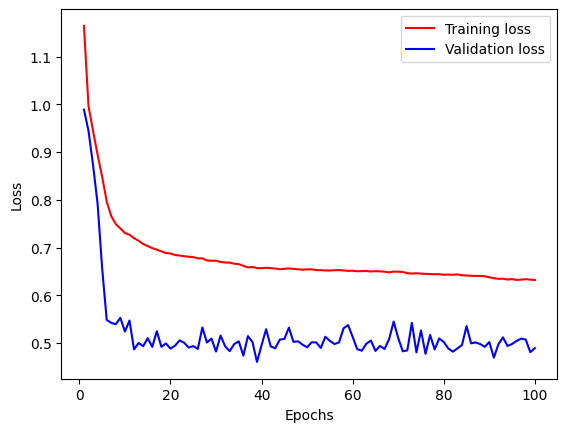

In [55]:
Loss = History.history["loss"]
ValLoss = History.history["val_loss"]
Epochs = range(1, len(Loss) + 1)

plt.plot(Epochs, Loss, "r", label="Training loss")
plt.plot(Epochs, ValLoss, "b", label="Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
    
plt.savefig(ResultsDir + "Loss_vs_Epochs.png")

In [56]:
Model.save(ResultsDir + "Model.h5")

ModelTest = tf.keras.models.load_model(ResultsDir + "Model.h5")
TestingOutputs = ModelTest.predict({"cnn_input": TestingInputs_CNN, "dnn_input": TestingInputs_DNN},
                                   batch_size = 5000)

120/120 [==============================] - 0s 2ms/step


In [57]:
TestingOutputs[0] #ML raw output is the probability of 3 sparse categories

array([2.8521245e-04, 7.6337075e-01, 2.3634404e-01], dtype=float32)

In [58]:
TestingPredictions = np.argmax(TestingOutputs, axis = 1) #pick the highest probability as ML output

In [59]:
print(TestingPredictions.shape)
print(TestingPredictions[0])

(600000,)
1


In [60]:
TestingDF["Pred"] = TestingPredictions.tolist()

In [61]:
TestingDF

,y12,y34,y13,y24,y14,y23,fourjetmasstev,Mjj_msortedP1_high_div4jm,Mjj_msortedP2_high_div4jm,Mjj_msortedP3_high_div4jm,Mjj_msortedP1_high,Mjj_msortedP1_low,Mjj_msortedP2_high,Mjj_msortedP2_low,Mjj_msortedP3_high,Mjj_msortedP3_low,Mjj_avg_dRpairing_GeV,pt_ordered_jet1_pt,pt_ordered_jet1_eta,pt_ordered_jet1_phi,pt_ordered_jet1_m,pt_ordered_jet2_pt,pt_ordered_jet2_eta,pt_ordered_jet2_phi,pt_ordered_jet2_m,pt_ordered_jet3_pt,pt_ordered_jet3_eta,pt_ordered_jet3_phi,pt_ordered_jet3_m,pt_ordered_jet4_pt,pt_ordered_jet4_eta,pt_ordered_jet4_phi,pt_ordered_jet4_m,evt_trig,Mass,P1M,P2M,P3M,dRi,Truth_high,Truth_avg,P1QSMD,P2QSMD,P3QSMD,Truth_QSMD,y1_sum,y1_diff,y2_sum,y2_diff,y3_sum,y3_diff,Pred,dR_M,Truth_high_M,Truth_avg_M,Pred_M,dR_M_high,Truth_high_M_high,Truth_avg_M_high,Pred_M_high,dR_QSMD,Truth_high_QSMD,Truth_avg_QSMD,Pred_QSMD
0,-0.385314,-0.292828,-0.304943,-0.410875,-0.762117,0.063545,1.665246,0.650471,0.406185,0.366546,1.083193,0.373950,0.676399,0.612059,0.610390,0.527888,0.569139,0.562562,-0.637817,3.111328,88.057571,0.496791,-0.107071,0.380310,57.543720,0.244333,0.406372,-1.575928,16.302513,0.194699,-1.140137,-1.516113,20.151115,1,500,728.571582,644.228805,569.138607,2,2,2,3.560032e+05,4.367370e+04,1.296359e+04,2,0.678142,0.092486,0.715818,0.105932,0.698572,0.825663,1,569.138607,569.138607,569.138607,644.228805,610.389668,610.389668,610.389668,676.398680,1.296359e+04,1.296359e+04,1.296359e+04,4.367370e+04
1,-0.217832,-0.006325,-0.125562,-0.156699,-0.164723,-0.116783,1.109070,0.634266,0.448905,0.308877,0.703446,0.375377,0.497867,0.468088,0.342566,0.128955,0.235760,0.361619,-0.222717,-2.445801,29.381573,0.338603,-0.214935,0.667236,40.997829,0.229120,0.026546,2.607910,14.359166,0.176884,-0.048973,0.241089,24.142027,1,500,539.411181,482.977846,235.760461,2,1,1,5.692109e+04,1.022894e+03,1.624600e+05,1,0.224157,0.211507,0.282261,0.031137,0.281507,0.047940,1,235.760461,482.977846,482.977846,482.977846,342.566192,497.867207,497.867207,497.867207,1.624600e+05,1.022894e+03,1.022894e+03,1.022894e+03
2,0.238854,0.581879,0.725073,-0.122710,0.206642,0.531022,1.522245,0.581316,0.488398,0.337147,0.884906,0.596236,0.743461,0.438657,0.513220,0.434524,0.473872,0.481394,0.434204,-2.622070,83.461464,0.381080,-0.001941,0.601807,35.842926,0.290538,1.213867,1.445312,27.096323,0.172561,-0.388794,-1.342041,18.913429,1,500,740.570848,591.058789,473.871794,2,2,2,1.574138e+05,6.303615e+04,4.461916e+03,2,0.820733,0.343024,0.602363,0.847783,0.737664,0.324380,0,473.871794,473.871794,473.871794,473.871794,513.219915,513.219915,513.219915,513.219915,4.461916e+03,4.461916e+03,4.461916e+03,4.461916e+03
3,-0.633889,-0.193005,-0.791055,-0.319948,-0.635317,-0.502395,2.525532,0.859122,0.317233,0.278710,2.169740,0.265412,0.801181,0.651792,0.703891,0.241316,0.472604,1.214417,-0.781372,1.698242,71.656212,0.945126,-0.447388,-1.610107,65.245651,0.132287,-0.897705,-1.162109,20.544504,0.101560,0.682007,0.441833,18.705877,1,500,1217.576412,726.486396,472.603865,2,2,2,2.843065e+06,1.137507e+05,1.084890e+05,2,0.826894,0.440883,1.111003,0.471107,1.137712,0.132922,1,472.603865,472.603865,472.603865,726.486396,703.891486,703.891486,703.891486,801.180826,1.084890e+05,1.084890e+05,1.084890e+05,1.137507e+05
4,0.687157,0.112902,0.555835,0.426765,0.607989,0.402100,1.569428,0.596522,0.572933,0.326371,0.936199,0.199743,0.899177,0.482994,0.512215,0.500105,0.567971,0.608950,0.765869,1.446533,41.903107,0.429987,0.579590,-2.564453,33.427315,0.320714,0.167755,-1.186768,25.589222,0.145860,-0.006079,-0.268311,15.420252,1,500,567.971112,691.085306,506.160069,0,2,2,2.804235e+05,1.596315e+05,1.492244e+02,2,0.800059,0.574255,0.982600,0.129070,1.010089,0.205889,2,567.971112,506.160069,506.160069,506.160069,936.198882,512.215294,512.215294,512.215294,2.804235e+05,1.492244e+02,1.492244e+02,1.492244e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [62]:
AccPred = []
AccdR = []
Acc0 = []
Acc1 = []
Acc2 = []
for Mass in Masses:
    TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]
    TestingDF_pred = TestingDF_temp.loc[TestingDF_temp["Pred"]==TestingDF_temp["Truth_QSMD"]]
    TestingDF_dR = TestingDF_temp.loc[TestingDF_temp["dRi"]==TestingDF_temp["Truth_QSMD"]]
    TestingDF_0 = TestingDF_temp.loc[0==TestingDF_temp["Truth_QSMD"]]
    TestingDF_1 = TestingDF_temp.loc[1==TestingDF_temp["Truth_QSMD"]]
    TestingDF_2 = TestingDF_temp.loc[2==TestingDF_temp["Truth_QSMD"]]

    AccPred.append(float(len(TestingDF_pred.index))/len(TestingDF_temp.index))
    AccdR.append(float(len(TestingDF_dR.index))/len(TestingDF_temp.index))
    Acc0.append(float(len(TestingDF_0.index))/len(TestingDF_temp.index))
    Acc1.append(float(len(TestingDF_1.index))/len(TestingDF_temp.index))
    Acc2.append(float(len(TestingDF_2.index))/len(TestingDF_temp.index))

In [63]:
AccPredAvg = "Avg %.2f" % float(sum(AccPred)/len(AccPred))
AccdRAvg = "Avg %.2f" % float(sum(AccdR)/len(AccdR))
Acc0Avg = "Avg %.2f" % float(sum(Acc0)/len(Acc0))
Acc1Avg = "Avg %.2f" % float(sum(Acc1)/len(Acc1))
Acc2Avg = "Avg %.2f" % float(sum(Acc2)/len(Acc2))

print(["%.2f" % i for i in AccPred], AccPredAvg)
print(["%.2f" % i for i in AccdR], AccdRAvg)
print(["%.2f" % i for i in Acc0], Acc0Avg)
print(["%.2f" % i for i in Acc1], Acc1Avg)
print(["%.2f" % i for i in Acc2], Acc2Avg)

['0.65', '0.76', '0.79', '0.80', '0.81', '0.81', '0.81', '0.81', '0.81', '0.80', '0.81', '0.81'] Avg 0.79
['0.40', '0.26', '0.20', '0.18', '0.15', '0.14', '0.12', '0.11', '0.11', '0.11', '0.10', '0.07'] Avg 0.16
['0.04', '0.10', '0.14', '0.16', '0.17', '0.17', '0.19', '0.20', '0.19', '0.19', '0.17', '0.16'] Avg 0.16
['0.30', '0.40', '0.43', '0.46', '0.47', '0.48', '0.49', '0.51', '0.51', '0.51', '0.51', '0.54'] Avg 0.47
['0.65', '0.50', '0.43', '0.39', '0.37', '0.35', '0.32', '0.30', '0.29', '0.30', '0.32', '0.29'] Avg 0.37


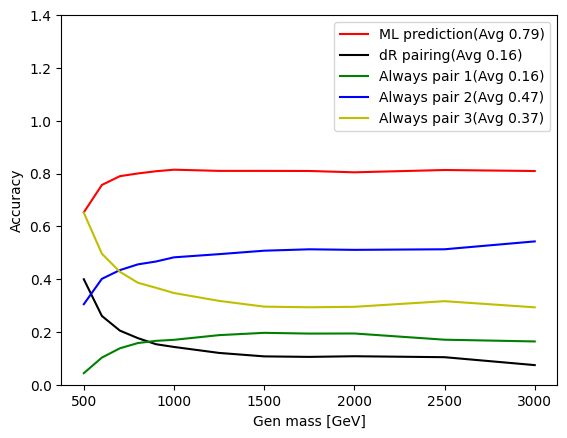

In [64]:
plt.plot(Masses, AccPred, "r", label = "ML prediction(" + AccPredAvg + ")")
plt.plot(Masses, AccdR, "k", label = "dR pairing(" + AccdRAvg + ")")
plt.plot(Masses, Acc0, "g", label = "Always pair 1(" + Acc0Avg + ")")
plt.plot(Masses, Acc1, "b", label = "Always pair 2(" + Acc1Avg + ")")
plt.plot(Masses, Acc2, "y", label = "Always pair 3(" + Acc2Avg + ")")
plt.legend()
plt.xlabel("Gen mass [GeV]")
plt.ylabel("Accuracy")
plt.ylim(0, 1.4)
plt.savefig(ResultsDir + "Accuracy_vs_mass.png")

In [65]:
P1Mi = TestingDF.columns.get_loc("P1M")
#TestingDF["dR_M"] = TestingDF.apply(lambda row: row.iloc[row["dRi"]], axis=1)
TestingDF["dR_M"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1Mi + TestingDF["dRi"]]
TestingDF["Truth_high_M"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1Mi + TestingDF["Truth_high"]]
TestingDF["Truth_avg_M"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1Mi + TestingDF["Truth_avg"]]
TestingDF["Pred_M"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1Mi + TestingDF["Pred"]]
TestingDF

,y12,y34,y13,y24,y14,y23,fourjetmasstev,Mjj_msortedP1_high_div4jm,Mjj_msortedP2_high_div4jm,Mjj_msortedP3_high_div4jm,Mjj_msortedP1_high,Mjj_msortedP1_low,Mjj_msortedP2_high,Mjj_msortedP2_low,Mjj_msortedP3_high,Mjj_msortedP3_low,Mjj_avg_dRpairing_GeV,pt_ordered_jet1_pt,pt_ordered_jet1_eta,pt_ordered_jet1_phi,pt_ordered_jet1_m,pt_ordered_jet2_pt,pt_ordered_jet2_eta,pt_ordered_jet2_phi,pt_ordered_jet2_m,pt_ordered_jet3_pt,pt_ordered_jet3_eta,pt_ordered_jet3_phi,pt_ordered_jet3_m,pt_ordered_jet4_pt,pt_ordered_jet4_eta,pt_ordered_jet4_phi,pt_ordered_jet4_m,evt_trig,Mass,P1M,P2M,P3M,dRi,Truth_high,Truth_avg,P1QSMD,P2QSMD,P3QSMD,Truth_QSMD,y1_sum,y1_diff,y2_sum,y2_diff,y3_sum,y3_diff,Pred,dR_M,Truth_high_M,Truth_avg_M,Pred_M,dR_M_high,Truth_high_M_high,Truth_avg_M_high,Pred_M_high,dR_QSMD,Truth_high_QSMD,Truth_avg_QSMD,Pred_QSMD
0,-0.385314,-0.292828,-0.304943,-0.410875,-0.762117,0.063545,1.665246,0.650471,0.406185,0.366546,1.083193,0.373950,0.676399,0.612059,0.610390,0.527888,0.569139,0.562562,-0.637817,3.111328,88.057571,0.496791,-0.107071,0.380310,57.543720,0.244333,0.406372,-1.575928,16.302513,0.194699,-1.140137,-1.516113,20.151115,1,500,728.571582,644.228805,569.138607,2,2,2,3.560032e+05,4.367370e+04,1.296359e+04,2,0.678142,0.092486,0.715818,0.105932,0.698572,0.825663,1,569.138607,569.138607,569.138607,644.228805,610.389668,610.389668,610.389668,676.398680,1.296359e+04,1.296359e+04,1.296359e+04,4.367370e+04
1,-0.217832,-0.006325,-0.125562,-0.156699,-0.164723,-0.116783,1.109070,0.634266,0.448905,0.308877,0.703446,0.375377,0.497867,0.468088,0.342566,0.128955,0.235760,0.361619,-0.222717,-2.445801,29.381573,0.338603,-0.214935,0.667236,40.997829,0.229120,0.026546,2.607910,14.359166,0.176884,-0.048973,0.241089,24.142027,1,500,539.411181,482.977846,235.760461,2,1,1,5.692109e+04,1.022894e+03,1.624600e+05,1,0.224157,0.211507,0.282261,0.031137,0.281507,0.047940,1,235.760461,482.977846,482.977846,482.977846,342.566192,497.867207,497.867207,497.867207,1.624600e+05,1.022894e+03,1.022894e+03,1.022894e+03
2,0.238854,0.581879,0.725073,-0.122710,0.206642,0.531022,1.522245,0.581316,0.488398,0.337147,0.884906,0.596236,0.743461,0.438657,0.513220,0.434524,0.473872,0.481394,0.434204,-2.622070,83.461464,0.381080,-0.001941,0.601807,35.842926,0.290538,1.213867,1.445312,27.096323,0.172561,-0.388794,-1.342041,18.913429,1,500,740.570848,591.058789,473.871794,2,2,2,1.574138e+05,6.303615e+04,4.461916e+03,2,0.820733,0.343024,0.602363,0.847783,0.737664,0.324380,0,473.871794,473.871794,473.871794,740.570848,513.219915,513.219915,513.219915,513.219915,4.461916e+03,4.461916e+03,4.461916e+03,4.461916e+03
3,-0.633889,-0.193005,-0.791055,-0.319948,-0.635317,-0.502395,2.525532,0.859122,0.317233,0.278710,2.169740,0.265412,0.801181,0.651792,0.703891,0.241316,0.472604,1.214417,-0.781372,1.698242,71.656212,0.945126,-0.447388,-1.610107,65.245651,0.132287,-0.897705,-1.162109,20.544504,0.101560,0.682007,0.441833,18.705877,1,500,1217.576412,726.486396,472.603865,2,2,2,2.843065e+06,1.137507e+05,1.084890e+05,2,0.826894,0.440883,1.111003,0.471107,1.137712,0.132922,1,472.603865,472.603865,472.603865,726.486396,703.891486,703.891486,703.891486,801.180826,1.084890e+05,1.084890e+05,1.084890e+05,1.137507e+05
4,0.687157,0.112902,0.555835,0.426765,0.607989,0.402100,1.569428,0.596522,0.572933,0.326371,0.936199,0.199743,0.899177,0.482994,0.512215,0.500105,0.567971,0.608950,0.765869,1.446533,41.903107,0.429987,0.579590,-2.564453,33.427315,0.320714,0.167755,-1.186768,25.589222,0.145860,-0.006079,-0.268311,15.420252,1,500,567.971112,691.085306,506.160069,0,2,2,2.804235e+05,1.596315e+05,1.492244e+02,2,0.800059,0.574255,0.982600,0.129070,1.010089,0.205889,2,567.971112,506.160069,506.160069,506.160069,936.198882,512.215294,512.215294,512.215294,2.804235e+05,1.492244e+02,1.492244e+02,1.492244e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

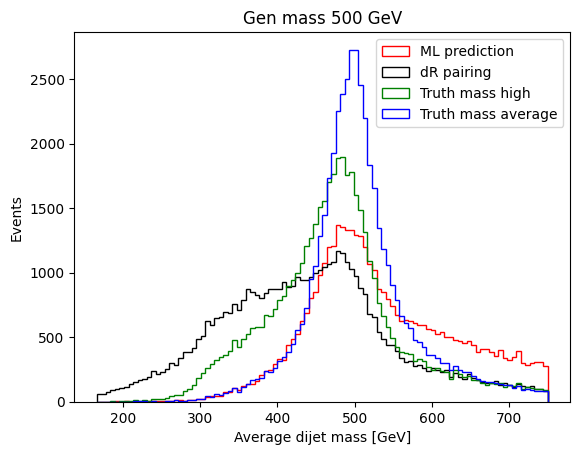

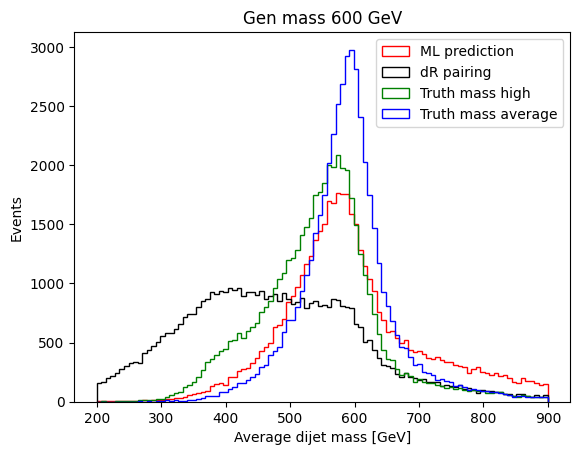

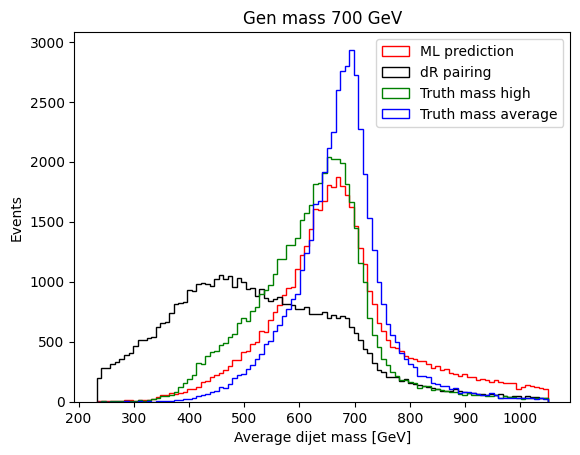

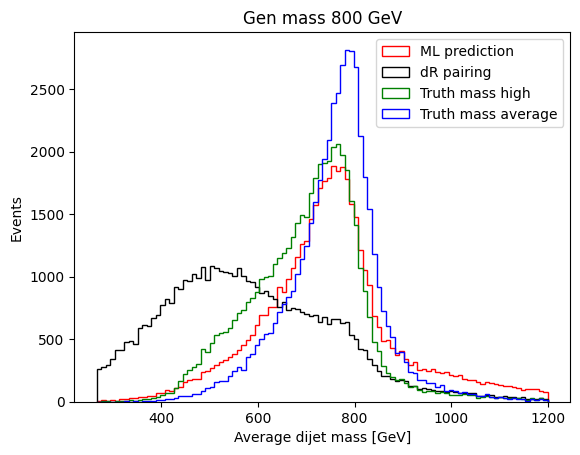

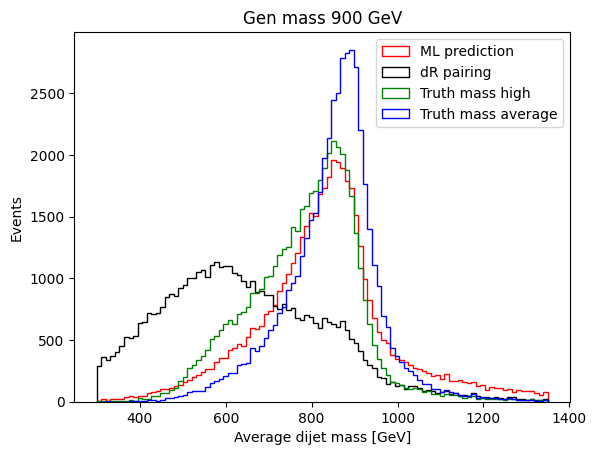

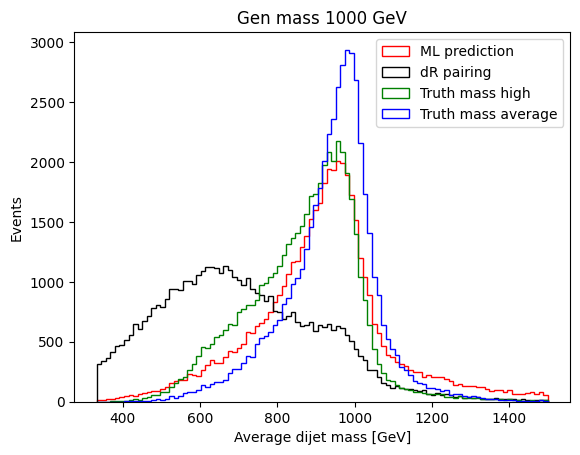

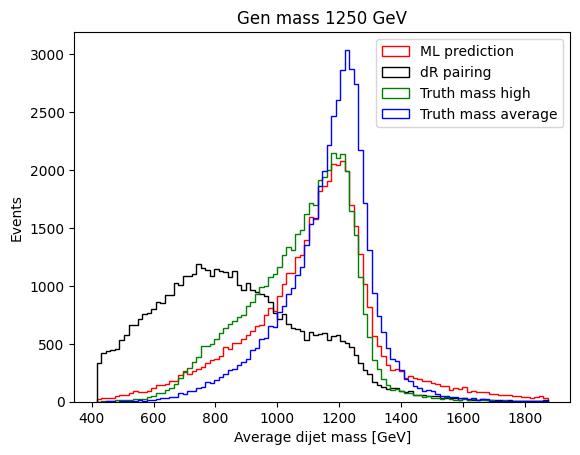

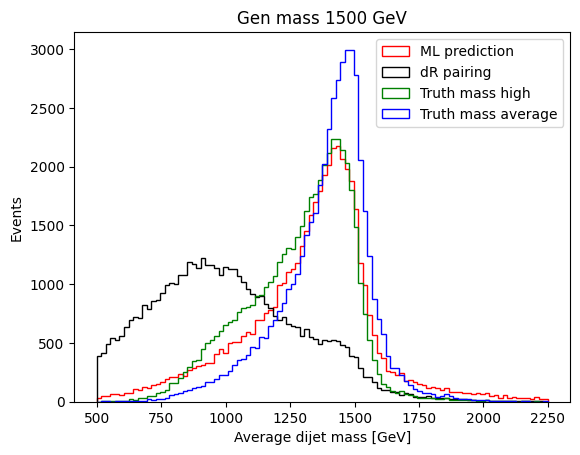

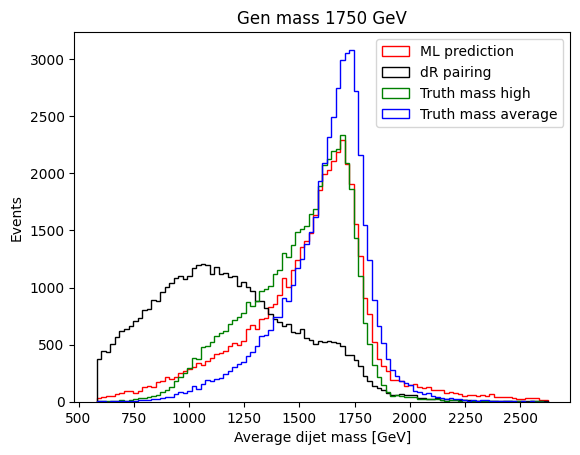

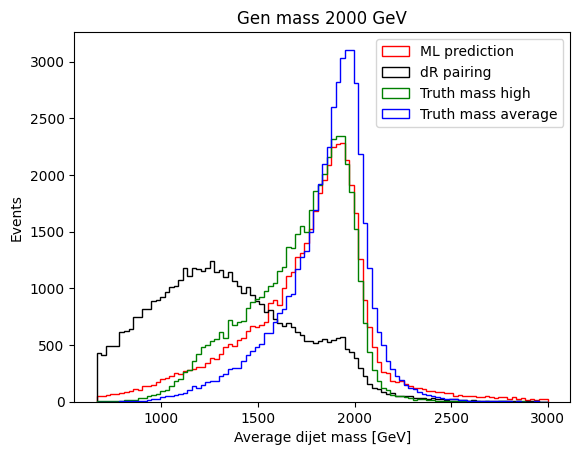

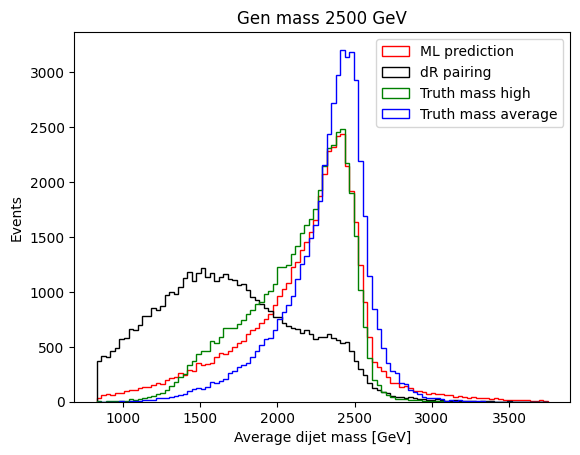

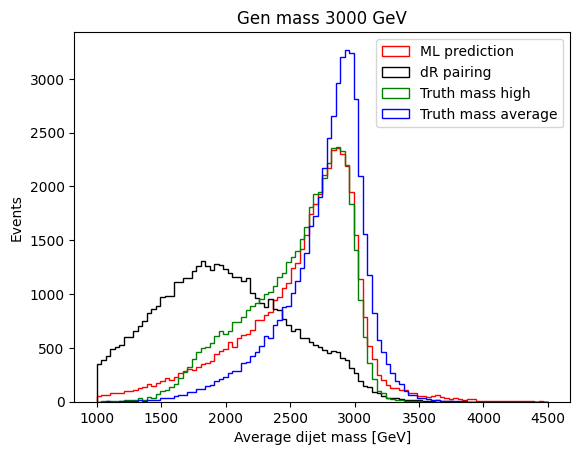

In [66]:
# for each gen mass sample, plot average dijet mass
for Mass in Masses:
    TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]
    plt.figure()
    plt.hist(TestingDF_temp["Pred_M"], bins = 100, range = [Mass/3, Mass*1.5], histtype = "step", color = "r", label = "ML prediction")
    plt.hist(TestingDF_temp["dR_M"], bins = 100, range = [Mass/3, Mass*1.5], histtype = "step", color = "k", label = "dR pairing")
    plt.hist(TestingDF_temp["Truth_high_M"], bins = 100, range = [Mass/3, Mass*1.5], histtype = "step", color = "g", label = "Truth mass high")
    plt.hist(TestingDF_temp["Truth_avg_M"], bins = 100, range = [Mass/3, Mass*1.5], histtype = "step", color = "b", label = "Truth mass average")
    plt.legend()
    plt.title("Gen mass " + str(Mass) + " GeV")
    plt.xlabel("Average dijet mass [GeV]")
    plt.ylabel("Events")
    plt.savefig(ResultsDir + "Average_dijet_mass_" + str(Mass) + "GeV.png")

In [67]:
P1M_high_i = TestingDF.columns.get_loc("Mjj_msortedP1_high")
TestingDF["dR_M_high"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1M_high_i + TestingDF["dRi"]*2] * 1000
TestingDF["Truth_high_M_high"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1M_high_i + TestingDF["Truth_high"]*2] * 1000
TestingDF["Truth_avg_M_high"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1M_high_i + TestingDF["Truth_avg"]*2] * 1000
TestingDF["Pred_M_high"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1M_high_i + TestingDF["Pred"]*2] * 1000
TestingDF

,y12,y34,y13,y24,y14,y23,fourjetmasstev,Mjj_msortedP1_high_div4jm,Mjj_msortedP2_high_div4jm,Mjj_msortedP3_high_div4jm,Mjj_msortedP1_high,Mjj_msortedP1_low,Mjj_msortedP2_high,Mjj_msortedP2_low,Mjj_msortedP3_high,Mjj_msortedP3_low,Mjj_avg_dRpairing_GeV,pt_ordered_jet1_pt,pt_ordered_jet1_eta,pt_ordered_jet1_phi,pt_ordered_jet1_m,pt_ordered_jet2_pt,pt_ordered_jet2_eta,pt_ordered_jet2_phi,pt_ordered_jet2_m,pt_ordered_jet3_pt,pt_ordered_jet3_eta,pt_ordered_jet3_phi,pt_ordered_jet3_m,pt_ordered_jet4_pt,pt_ordered_jet4_eta,pt_ordered_jet4_phi,pt_ordered_jet4_m,evt_trig,Mass,P1M,P2M,P3M,dRi,Truth_high,Truth_avg,P1QSMD,P2QSMD,P3QSMD,Truth_QSMD,y1_sum,y1_diff,y2_sum,y2_diff,y3_sum,y3_diff,Pred,dR_M,Truth_high_M,Truth_avg_M,Pred_M,dR_M_high,Truth_high_M_high,Truth_avg_M_high,Pred_M_high,dR_QSMD,Truth_high_QSMD,Truth_avg_QSMD,Pred_QSMD
0,-0.385314,-0.292828,-0.304943,-0.410875,-0.762117,0.063545,1.665246,0.650471,0.406185,0.366546,1.083193,0.373950,0.676399,0.612059,0.610390,0.527888,0.569139,0.562562,-0.637817,3.111328,88.057571,0.496791,-0.107071,0.380310,57.543720,0.244333,0.406372,-1.575928,16.302513,0.194699,-1.140137,-1.516113,20.151115,1,500,728.571582,644.228805,569.138607,2,2,2,3.560032e+05,4.367370e+04,1.296359e+04,2,0.678142,0.092486,0.715818,0.105932,0.698572,0.825663,1,569.138607,569.138607,569.138607,644.228805,610.389668,610.389668,610.389668,676.398680,1.296359e+04,1.296359e+04,1.296359e+04,4.367370e+04
1,-0.217832,-0.006325,-0.125562,-0.156699,-0.164723,-0.116783,1.109070,0.634266,0.448905,0.308877,0.703446,0.375377,0.497867,0.468088,0.342566,0.128955,0.235760,0.361619,-0.222717,-2.445801,29.381573,0.338603,-0.214935,0.667236,40.997829,0.229120,0.026546,2.607910,14.359166,0.176884,-0.048973,0.241089,24.142027,1,500,539.411181,482.977846,235.760461,2,1,1,5.692109e+04,1.022894e+03,1.624600e+05,1,0.224157,0.211507,0.282261,0.031137,0.281507,0.047940,1,235.760461,482.977846,482.977846,482.977846,342.566192,497.867207,497.867207,497.867207,1.624600e+05,1.022894e+03,1.022894e+03,1.022894e+03
2,0.238854,0.581879,0.725073,-0.122710,0.206642,0.531022,1.522245,0.581316,0.488398,0.337147,0.884906,0.596236,0.743461,0.438657,0.513220,0.434524,0.473872,0.481394,0.434204,-2.622070,83.461464,0.381080,-0.001941,0.601807,35.842926,0.290538,1.213867,1.445312,27.096323,0.172561,-0.388794,-1.342041,18.913429,1,500,740.570848,591.058789,473.871794,2,2,2,1.574138e+05,6.303615e+04,4.461916e+03,2,0.820733,0.343024,0.602363,0.847783,0.737664,0.324380,0,473.871794,473.871794,473.871794,740.570848,513.219915,513.219915,513.219915,884.905691,4.461916e+03,4.461916e+03,4.461916e+03,4.461916e+03
3,-0.633889,-0.193005,-0.791055,-0.319948,-0.635317,-0.502395,2.525532,0.859122,0.317233,0.278710,2.169740,0.265412,0.801181,0.651792,0.703891,0.241316,0.472604,1.214417,-0.781372,1.698242,71.656212,0.945126,-0.447388,-1.610107,65.245651,0.132287,-0.897705,-1.162109,20.544504,0.101560,0.682007,0.441833,18.705877,1,500,1217.576412,726.486396,472.603865,2,2,2,2.843065e+06,1.137507e+05,1.084890e+05,2,0.826894,0.440883,1.111003,0.471107,1.137712,0.132922,1,472.603865,472.603865,472.603865,726.486396,703.891486,703.891486,703.891486,801.180826,1.084890e+05,1.084890e+05,1.084890e+05,1.137507e+05
4,0.687157,0.112902,0.555835,0.426765,0.607989,0.402100,1.569428,0.596522,0.572933,0.326371,0.936199,0.199743,0.899177,0.482994,0.512215,0.500105,0.567971,0.608950,0.765869,1.446533,41.903107,0.429987,0.579590,-2.564453,33.427315,0.320714,0.167755,-1.186768,25.589222,0.145860,-0.006079,-0.268311,15.420252,1,500,567.971112,691.085306,506.160069,0,2,2,2.804235e+05,1.596315e+05,1.492244e+02,2,0.800059,0.574255,0.982600,0.129070,1.010089,0.205889,2,567.971112,506.160069,506.160069,506.160069,936.198882,512.215294,512.215294,512.215294,2.804235e+05,1.492244e+02,1.492244e+02,1.492244e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

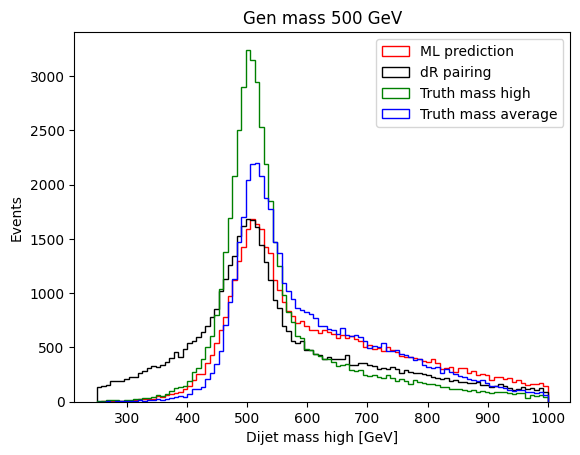

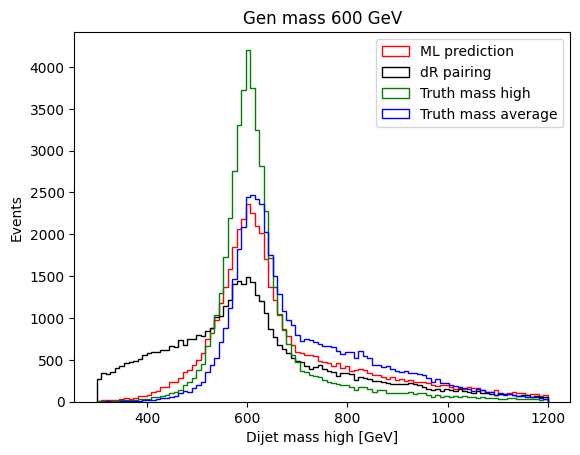

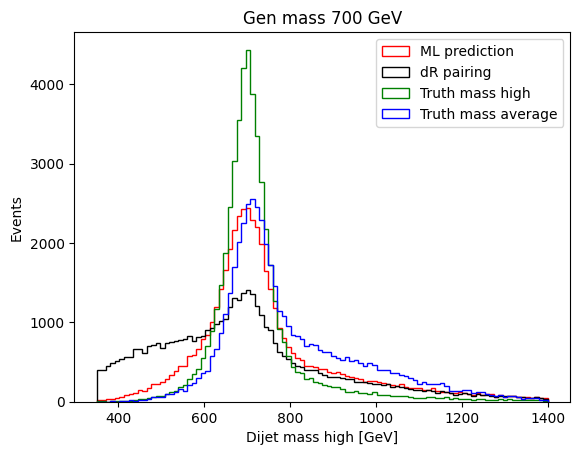

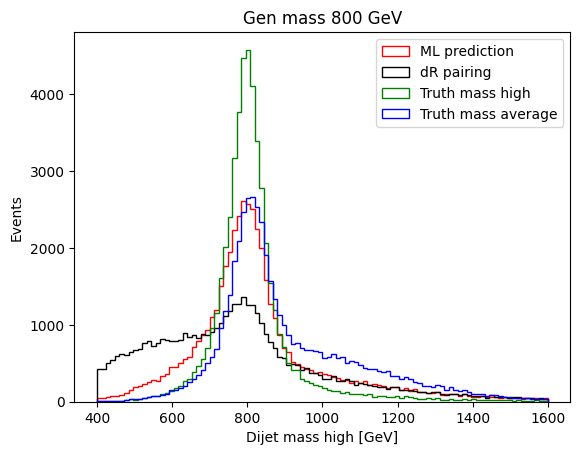

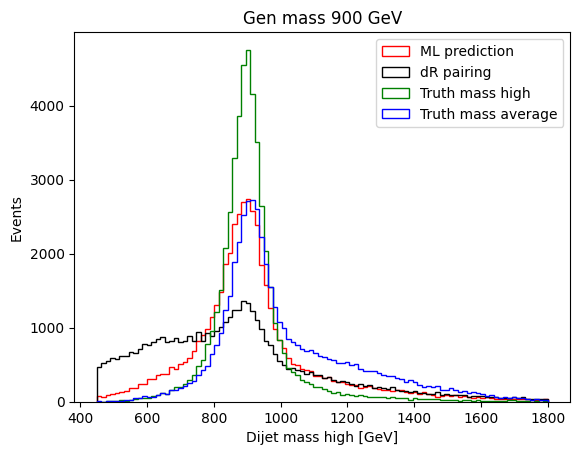

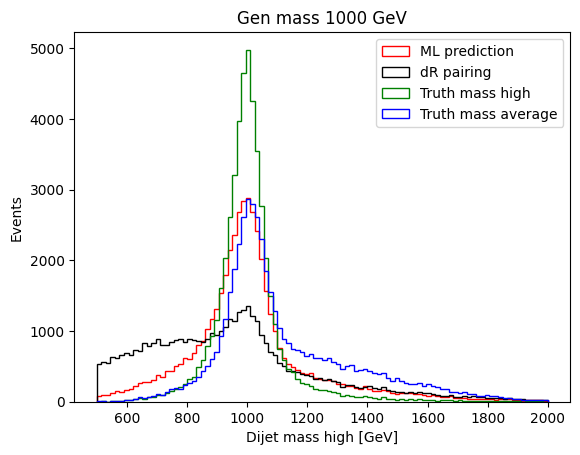

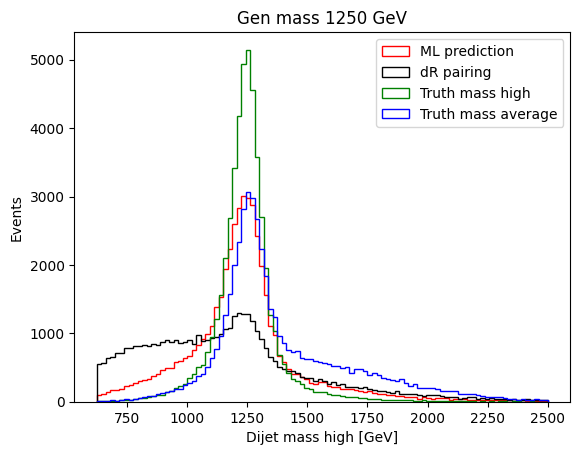

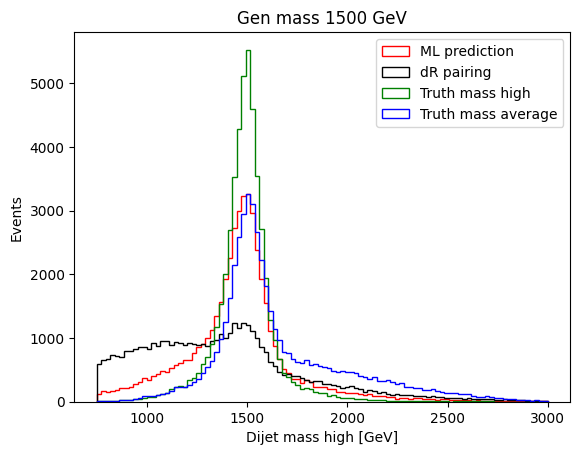

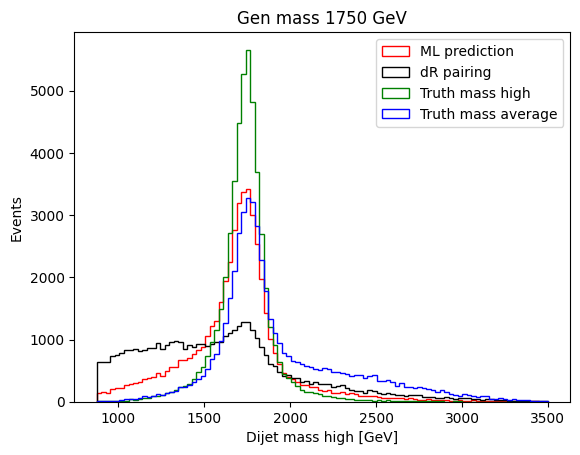

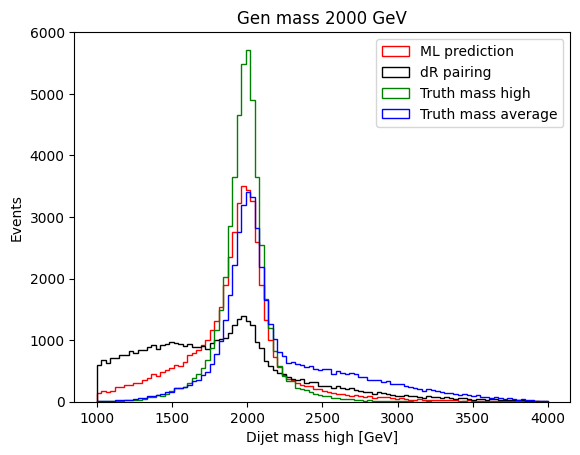

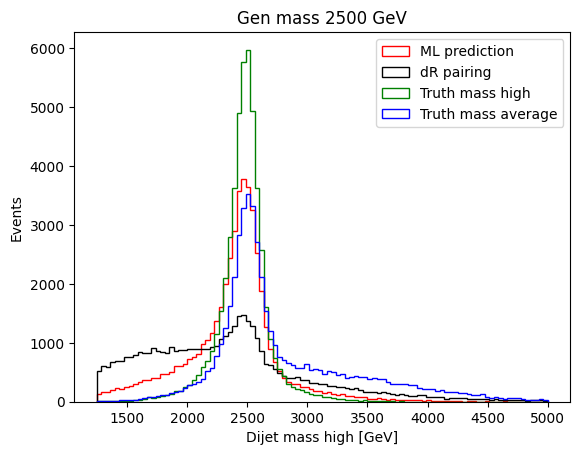

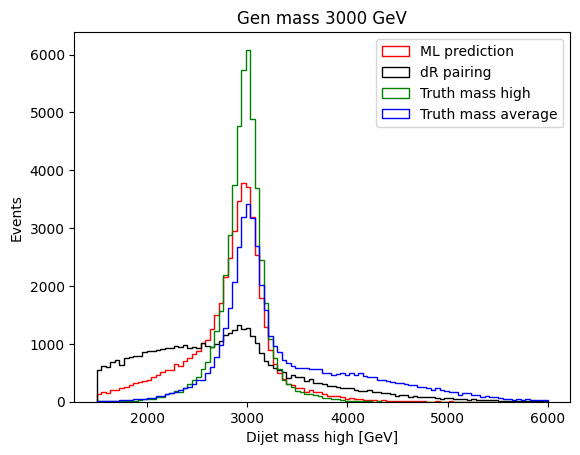

In [68]:
# for each gen mass sample, plot dijet mass high
for Mass in Masses:
    TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]
    plt.figure()
    plt.hist(TestingDF_temp["Pred_M_high"], bins = 100, range = [Mass/2, Mass*2], histtype = "step", color = "r", label = "ML prediction")
    plt.hist(TestingDF_temp["dR_M_high"], bins = 100, range = [Mass/2, Mass*2], histtype = "step", color = "k", label = "dR pairing")
    plt.hist(TestingDF_temp["Truth_high_M_high"], bins = 100, range = [Mass/2, Mass*2], histtype = "step", color = "g", label = "Truth mass high")
    plt.hist(TestingDF_temp["Truth_avg_M_high"], bins = 100, range = [Mass/2, Mass*2], histtype = "step", color = "b", label = "Truth mass average")
    plt.legend(loc="upper right")
    plt.title("Gen mass " + str(Mass) + " GeV")
    plt.xlabel("Dijet mass high [GeV]")
    plt.ylabel("Events")
    plt.savefig(ResultsDir + "Dijet_mass_high_" + str(Mass) + "GeV.png")

In [69]:
P1QSMDi = TestingDF.columns.get_loc("P1QSMD")
TestingDF["dR_QSMD"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1QSMDi + TestingDF["dRi"]]
TestingDF["Truth_high_QSMD"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1QSMDi + TestingDF["Truth_high"]]
TestingDF["Truth_avg_QSMD"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1QSMDi + TestingDF["Truth_avg"]]
TestingDF["Pred_QSMD"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1QSMDi + TestingDF["Pred"]]
TestingDF

,y12,y34,y13,y24,y14,y23,fourjetmasstev,Mjj_msortedP1_high_div4jm,Mjj_msortedP2_high_div4jm,Mjj_msortedP3_high_div4jm,Mjj_msortedP1_high,Mjj_msortedP1_low,Mjj_msortedP2_high,Mjj_msortedP2_low,Mjj_msortedP3_high,Mjj_msortedP3_low,Mjj_avg_dRpairing_GeV,pt_ordered_jet1_pt,pt_ordered_jet1_eta,pt_ordered_jet1_phi,pt_ordered_jet1_m,pt_ordered_jet2_pt,pt_ordered_jet2_eta,pt_ordered_jet2_phi,pt_ordered_jet2_m,pt_ordered_jet3_pt,pt_ordered_jet3_eta,pt_ordered_jet3_phi,pt_ordered_jet3_m,pt_ordered_jet4_pt,pt_ordered_jet4_eta,pt_ordered_jet4_phi,pt_ordered_jet4_m,evt_trig,Mass,P1M,P2M,P3M,dRi,Truth_high,Truth_avg,P1QSMD,P2QSMD,P3QSMD,Truth_QSMD,y1_sum,y1_diff,y2_sum,y2_diff,y3_sum,y3_diff,Pred,dR_M,Truth_high_M,Truth_avg_M,Pred_M,dR_M_high,Truth_high_M_high,Truth_avg_M_high,Pred_M_high,dR_QSMD,Truth_high_QSMD,Truth_avg_QSMD,Pred_QSMD
0,-0.385314,-0.292828,-0.304943,-0.410875,-0.762117,0.063545,1.665246,0.650471,0.406185,0.366546,1.083193,0.373950,0.676399,0.612059,0.610390,0.527888,0.569139,0.562562,-0.637817,3.111328,88.057571,0.496791,-0.107071,0.380310,57.543720,0.244333,0.406372,-1.575928,16.302513,0.194699,-1.140137,-1.516113,20.151115,1,500,728.571582,644.228805,569.138607,2,2,2,3.560032e+05,4.367370e+04,1.296359e+04,2,0.678142,0.092486,0.715818,0.105932,0.698572,0.825663,1,569.138607,569.138607,569.138607,644.228805,610.389668,610.389668,610.389668,676.398680,1.296359e+04,1.296359e+04,1.296359e+04,4.367370e+04
1,-0.217832,-0.006325,-0.125562,-0.156699,-0.164723,-0.116783,1.109070,0.634266,0.448905,0.308877,0.703446,0.375377,0.497867,0.468088,0.342566,0.128955,0.235760,0.361619,-0.222717,-2.445801,29.381573,0.338603,-0.214935,0.667236,40.997829,0.229120,0.026546,2.607910,14.359166,0.176884,-0.048973,0.241089,24.142027,1,500,539.411181,482.977846,235.760461,2,1,1,5.692109e+04,1.022894e+03,1.624600e+05,1,0.224157,0.211507,0.282261,0.031137,0.281507,0.047940,1,235.760461,482.977846,482.977846,482.977846,342.566192,497.867207,497.867207,497.867207,1.624600e+05,1.022894e+03,1.022894e+03,1.022894e+03
2,0.238854,0.581879,0.725073,-0.122710,0.206642,0.531022,1.522245,0.581316,0.488398,0.337147,0.884906,0.596236,0.743461,0.438657,0.513220,0.434524,0.473872,0.481394,0.434204,-2.622070,83.461464,0.381080,-0.001941,0.601807,35.842926,0.290538,1.213867,1.445312,27.096323,0.172561,-0.388794,-1.342041,18.913429,1,500,740.570848,591.058789,473.871794,2,2,2,1.574138e+05,6.303615e+04,4.461916e+03,2,0.820733,0.343024,0.602363,0.847783,0.737664,0.324380,0,473.871794,473.871794,473.871794,740.570848,513.219915,513.219915,513.219915,884.905691,4.461916e+03,4.461916e+03,4.461916e+03,1.574138e+05
3,-0.633889,-0.193005,-0.791055,-0.319948,-0.635317,-0.502395,2.525532,0.859122,0.317233,0.278710,2.169740,0.265412,0.801181,0.651792,0.703891,0.241316,0.472604,1.214417,-0.781372,1.698242,71.656212,0.945126,-0.447388,-1.610107,65.245651,0.132287,-0.897705,-1.162109,20.544504,0.101560,0.682007,0.441833,18.705877,1,500,1217.576412,726.486396,472.603865,2,2,2,2.843065e+06,1.137507e+05,1.084890e+05,2,0.826894,0.440883,1.111003,0.471107,1.137712,0.132922,1,472.603865,472.603865,472.603865,726.486396,703.891486,703.891486,703.891486,801.180826,1.084890e+05,1.084890e+05,1.084890e+05,1.137507e+05
4,0.687157,0.112902,0.555835,0.426765,0.607989,0.402100,1.569428,0.596522,0.572933,0.326371,0.936199,0.199743,0.899177,0.482994,0.512215,0.500105,0.567971,0.608950,0.765869,1.446533,41.903107,0.429987,0.579590,-2.564453,33.427315,0.320714,0.167755,-1.186768,25.589222,0.145860,-0.006079,-0.268311,15.420252,1,500,567.971112,691.085306,506.160069,0,2,2,2.804235e+05,1.596315e+05,1.492244e+02,2,0.800059,0.574255,0.982600,0.129070,1.010089,0.205889,2,567.971112,506.160069,506.160069,506.160069,936.198882,512.215294,512.215294,512.215294,2.804235e+05,1.492244e+02,1.492244e+02,1.492244e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

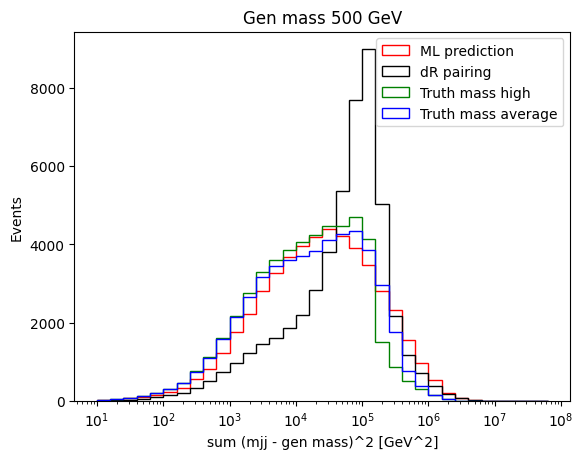

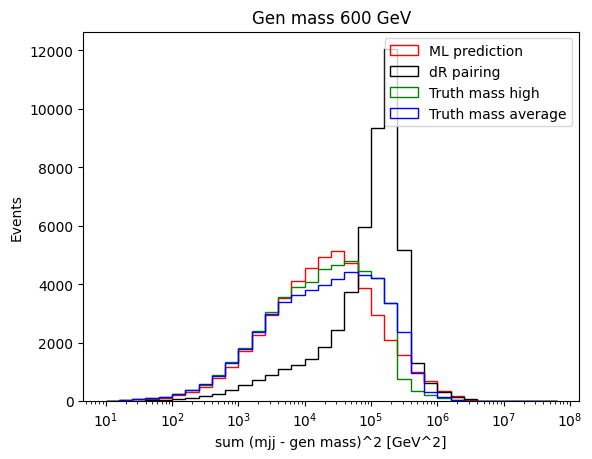

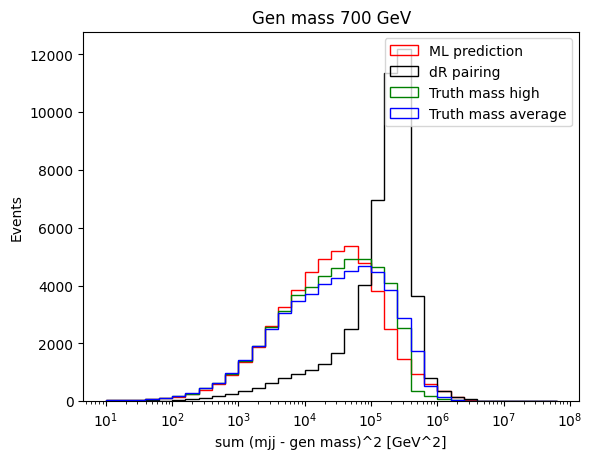

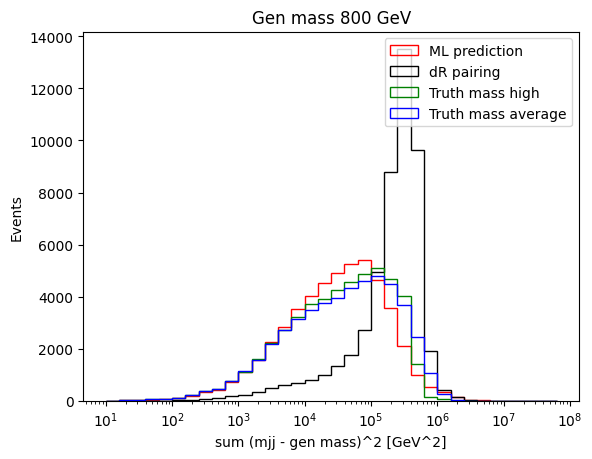

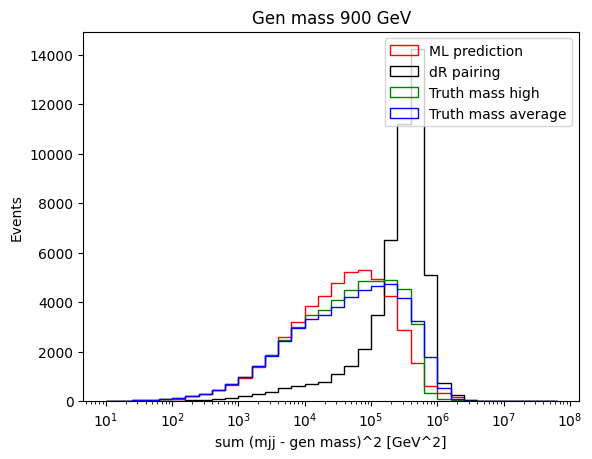

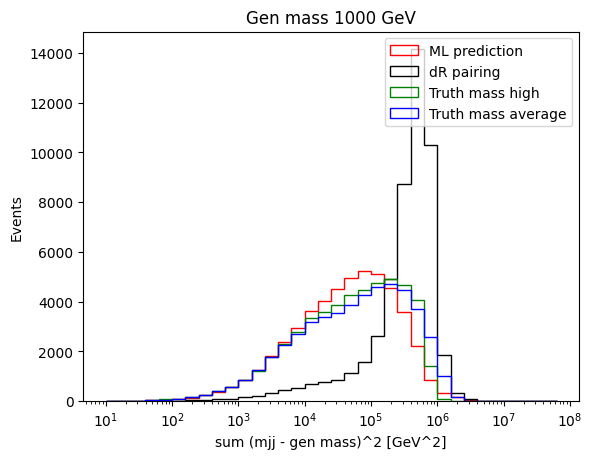

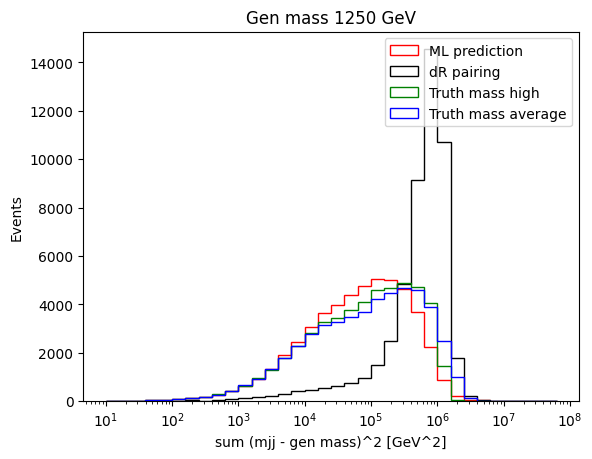

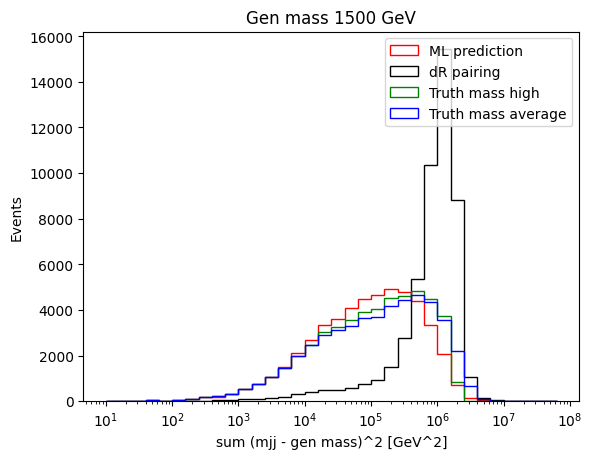

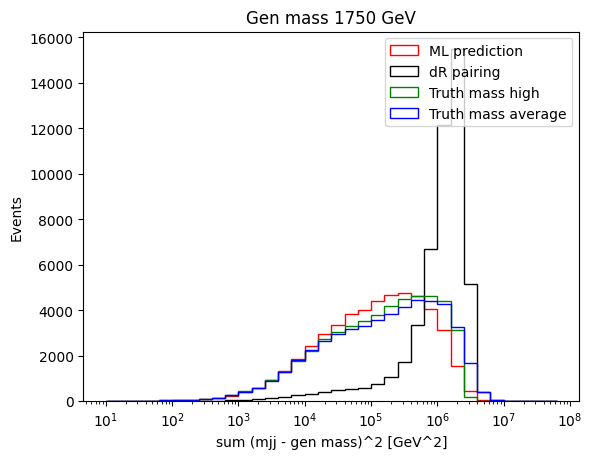

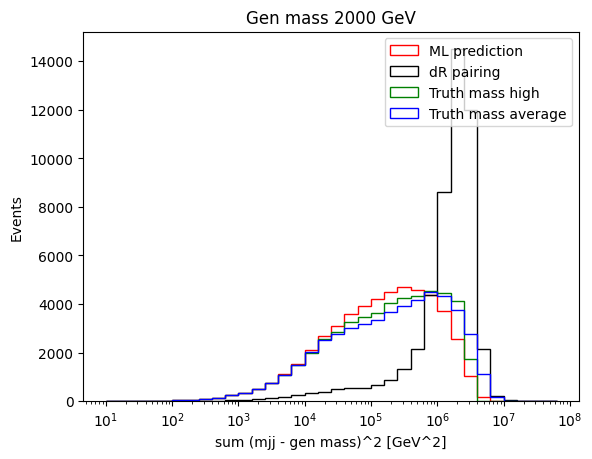

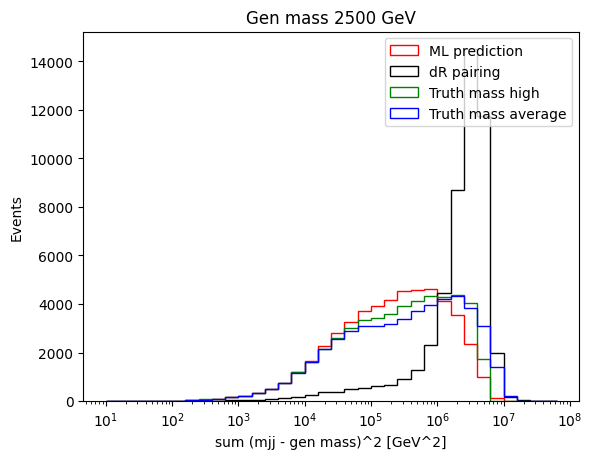

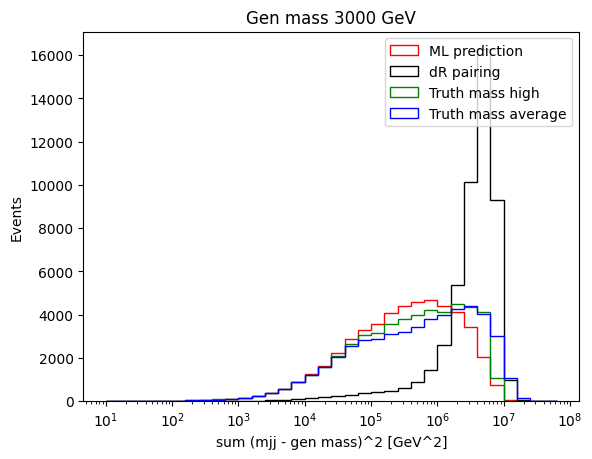

In [70]:
# for each gen mass sample, plot sum (mjj - gen mass)^2
for Mass in Masses:
    TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]
    Bins = [10**(x/5) for x in range(5,40)]
    plt.figure()
    plt.hist(TestingDF_temp["Pred_QSMD"], bins = Bins, histtype = "step", color = "r", label = "ML prediction")
    plt.hist(TestingDF_temp["dR_QSMD"], bins = Bins, histtype = "step", color = "k", label = "dR pairing")
    plt.hist(TestingDF_temp["Truth_high_QSMD"], bins = Bins, histtype = "step", color = "g", label = "Truth mass high")
    plt.hist(TestingDF_temp["Truth_avg_QSMD"], bins = Bins, histtype = "step", color = "b", label = "Truth mass average")
    plt.xscale('log')
    plt.legend()
    plt.title("Gen mass " + str(Mass) + " GeV")
    plt.xlabel("sum (mjj - gen mass)^2 [GeV^2]")
    plt.ylabel("Events")
    plt.savefig(ResultsDir + "Quad_sum_mass_diff_" + str(Mass) + "GeV.png")